20230510 16:45

submission 5 - 0.03741

epoch = 400, patience = 15, batch size = 16

```
autoencoder = keras.Sequential([
    layers.Input(shape=img_dim),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.BatchNormalization(),
    
    layers.Dropout(0.5),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])
```

In [1]:
import zipfile
import os
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import Data

### Unzip images into workspace directories

In [2]:
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'

with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
# list of image names
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

### Evaluate image dimensions

In [3]:
imgs = [cv2.imread(path + 'train/' + f) for f in sorted(os.listdir(path + 'train/'))]
dim1 = [len(img) for img in imgs]
dim2 = [len(img[0]) for img in imgs]
del imgs

In [4]:
ct_dim1 = Counter(dim1)
ct_dim2 = Counter(dim2)

print(ct_dim1)
print(ct_dim2)

Counter({420: 96, 258: 48})
Counter({540: 144})


For now, just use the mode dimension for simplicity(540, 420)
- note: this causes (540, 258) images to be stretched

## Preprocess Image

In [5]:
img_dim = (420, 540, 1)

In [6]:
def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (img_dim[1], img_dim[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_np = np.asarray(img, dtype="float32") 
    img_np /= 255.0
    img_np = np.reshape(img_np, img_dim) # expand to 3d
    return img_np

In [7]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(preprocess_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(preprocess_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(preprocess_image(path + 'test/' + f))

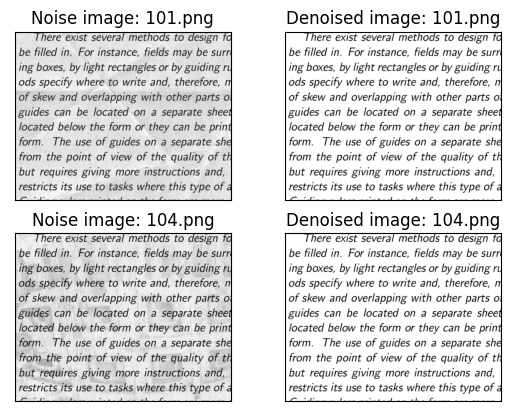

In [8]:
# plt.figure(figsize=(15,25))
for i in range(0,4,2):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(2,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

## Train test split
The data size is small, so use a smaller portion of validation set

In [9]:
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [10]:
print(X_train.shape)

(129, 420, 540, 1)


# Prepare Autoencoder

In [11]:
autoencoder = keras.Sequential([
    layers.Input(shape=img_dim),
    # encoder
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # decoder
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

In [12]:
print(autoencoder.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 210, 270, 256)     147712    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 105, 135, 256)    0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 105, 135, 256)    1024      
 ormalization)                                                   
                                                        

In [13]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mae']
                   )

In [14]:
callback = EarlyStopping(monitor='loss', patience=15)

hist = autoencoder.fit(X_train, y_train,
                epochs=10,
                batch_size=16,
                shuffle=True,
                validation_data=(X_val, y_val),
                callbacks=[callback],
               )

Epoch 1/10


2023-05-14 14:02:10.648660: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 20s 905ms/step - loss: 0.0783 - mae: 0.1451 - val_loss: 0.0837 - val_mae: 0.2615
Epoch 2/10
9/9 [==============================] - 4s 485ms/step - loss: 0.0334 - mae: 0.0792 - val_loss: 0.1275 - val_mae: 0.3462
Epoch 3/10
9/9 [==============================] - 4s 480ms/step - loss: 0.0232 - mae: 0.0661 - val_loss: 0.0892 - val_mae: 0.2822
Epoch 4/10
9/9 [==============================] - 4s 481ms/step - loss: 0.0190 - mae: 0.0585 - val_loss: 0.0922 - val_mae: 0.2881
Epoch 5/10
9/9 [==============================] - 4s 482ms/step - loss: 0.0162 - mae: 0.0525 - val_loss: 0.0654 - val_mae: 0.2207
Epoch 6/10
9/9 [==============================] - 4s 481ms/step - loss: 0.0144 - mae: 0.0493 - val_loss: 0.0573 - val_mae: 0.1805
Epoch 7/10
9/9 [==============================] - 4s 479ms/step - loss: 0.0132 - mae: 0.0472 - val_loss: 0.0564 - val_mae: 0.1451
Epoch 8/10
9/9 [==============================] - 4s 484ms/step - loss: 0.0122 - mae: 0.0441 - val_l

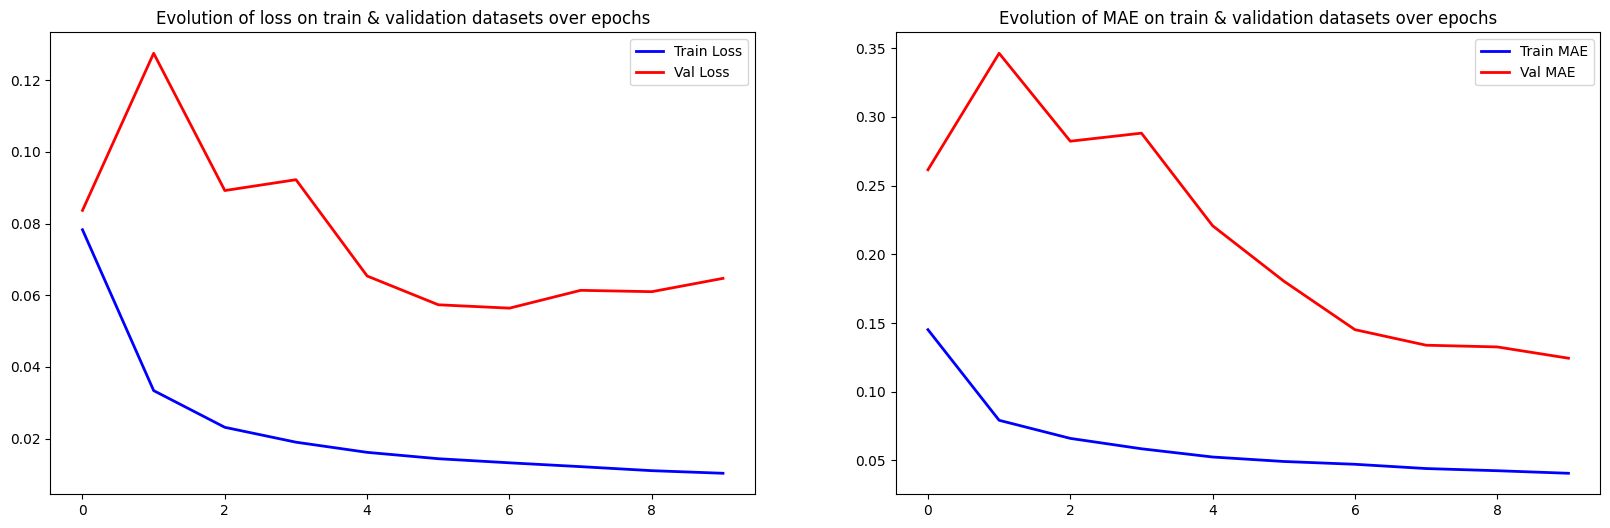

In [15]:
# Check how loss & mae went down
epoch_loss = hist.history['loss']
epoch_val_loss = hist.history['val_loss']
epoch_mae = hist.history['mae']
epoch_val_mae = hist.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

# Inference

In [16]:
X_test = np.asarray(test)

In [17]:
y_test = autoencoder.predict(X_test, batch_size=16)

5/5 [==============================] - 2s 585ms/step


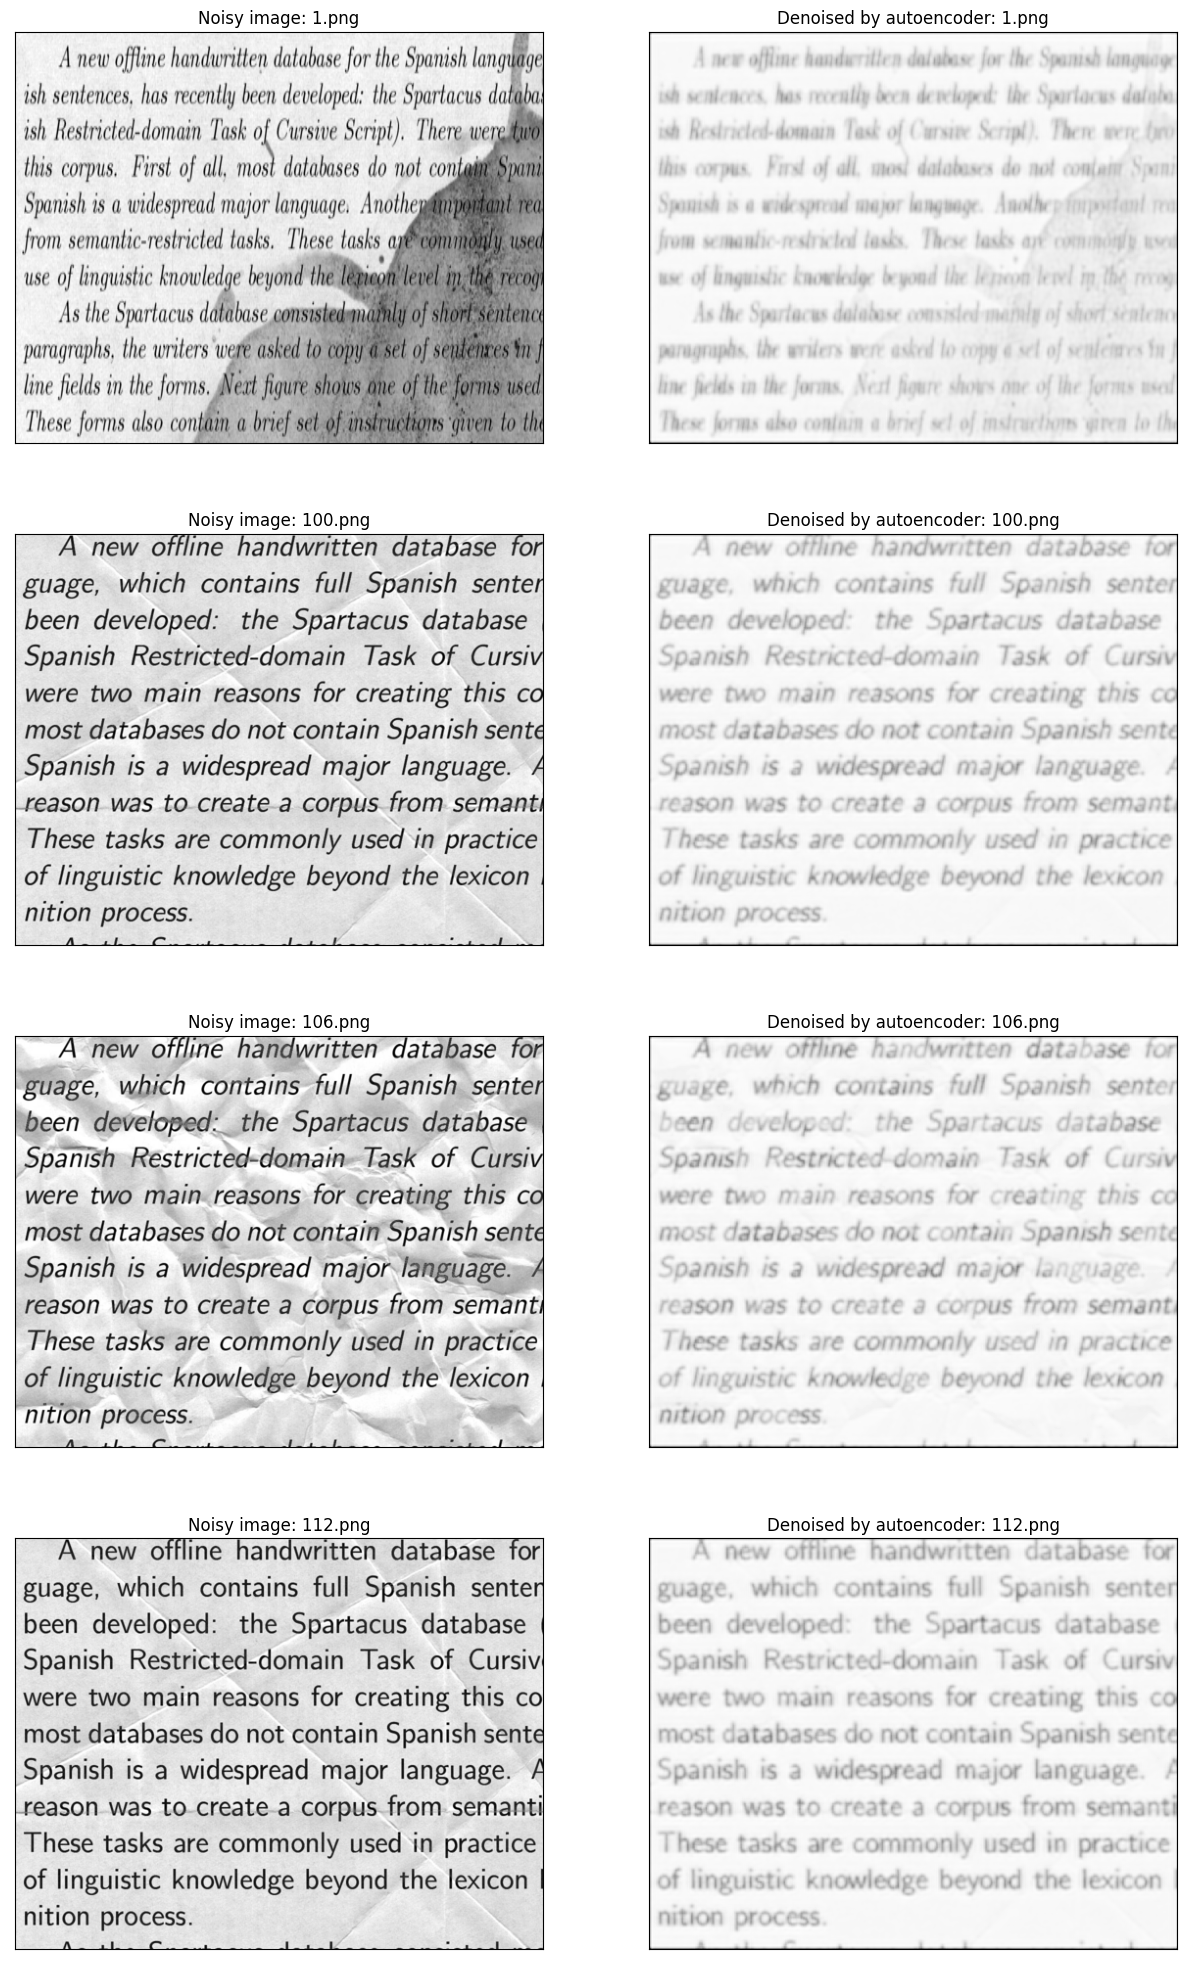

In [18]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [19]:
# it will take a while!
ids = []
vals = []
for i, f in enumerate(test_img):
    file = path + 'test/' + f
    imgid = int(f[:-4])
    img = cv2.imread(file, 0)
    img_shape = img.shape
    # print('Processing image: {} \tinto size: {}'.format(f, img_shape))    # uncomment to see progress
    preds_reshaped = cv2.resize(y_test[i], (img_shape[1], img_shape[0]))

    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

submission = pd.DataFrame({'id': ids, 'value': vals})
submission.to_csv('submission.csv',index = False)

print('Results saved to submission.csv!')
print('Length of IDs: {}'.format(len(ids)))

Results saved to submission.csv!
Length of IDs: 14230080


In [20]:
import shutil
shutil.rmtree(path + 'train/')
shutil.rmtree(path + 'test/')
shutil.rmtree(path + 'train_cleaned/')

In [21]:
df = pd.read_csv("/kaggle/working/submission.csv")